# Step 4 - Work on Speech

## Preprocessing the dataset

In [1]:
dataset = []

In [2]:
with open("data/quantized/LibriSpeech/train-full-960/quantized_outputs.txt") as input_file:
    for line in input_file.readlines():
        dataset.append(
            line.split("\t")[1].split(",")[1:]  # Exclude ID and get only data
        )

In [14]:
# Assign a character to each number
import string
letters = {
    i: key for i, key in enumerate(string.ascii_letters)
}

In [4]:
char_dataset = [
    [letters[int(v)] for i, v in enumerate(line) if i == 0 or v != line[i - 1]]
    for line in dataset
]

In [2]:
# Write new data to a file
char_dataset_filepath = "data/quantized_dataset.txt"

In [6]:
with open(char_dataset_filepath, "w+", encoding="utf-8") as char_ds_fp:
    for line in char_dataset:
        char_ds_fp.write("".join(line) + "\n")

## Run SentencePiece on new dataset

In [3]:
import sentencepiece as spm

In [4]:
input_file = char_dataset_filepath
version = "s4"
max_sentence_length = 5003
vocab_size = 19099
model_type = "unigram"
SP_MODEL_NAME = f"models/{model_type}_vs{vocab_size}_{version}"

In [9]:
# train sentencepiece model from `botchan.txt` and makes `m.model` and `m.vocab`
# `m.vocab` is just a reference. not used in the segmentation.
spm.SentencePieceTrainer.train(
    f"--input={input_file} " \
    f"--model_type={model_type} " \
    f"--model_prefix={SP_MODEL_NAME} " \
    f"--vocab_size={vocab_size} " \
    f"--max_sentence_length={max_sentence_length} " \
    f"--train_extremely_large_corpus"
)

In [5]:
# Convert sentences to token sequences
sp = spm.SentencePieceProcessor()
sp.load(f"{SP_MODEL_NAME}.model")

True

In [6]:
with open(input_file) as corpus_file:
    corpus = corpus_file.readlines()

sentences = [sp.EncodeAsPieces(sentence) for sentence in corpus]

KeyboardInterrupt: 

## Word2Vec

In [7]:
from gensim.models.word2vec import Word2Vec

In [8]:
vector_size = 100
window = 5
W2V_MODEL_PATH = f"models/w2v_vs{vector_size}_w{window}_{version}.model"

In [106]:
model = Word2Vec(
    sentences,
    window=window,
    vector_size=vector_size,
    min_count=0,
    workers=4
)

In [107]:
model.save(W2V_MODEL_PATH)

## Testing

In [9]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
model = Word2Vec.load(W2V_MODEL_PATH)

In [11]:
word_to_key = {}
key_to_word = {}

with open("data/quantized/dev-gold.csv", "r") as key_file:
    for line in key_file.readlines()[1:]:
        dataset, key, _, word = line.strip().split(",")
        if word not in word_to_key:
            word_to_key[word] = {
                'librispeech': [],
                'synthetic': []
            }
        word_to_key[word][dataset].append(key)
        key_to_word[key] = word

In [12]:
sim_pairs = []
rel_pairs = []

with open("data/quantized/dev-pairs.csv", "r") as pairs_file:
    for line in pairs_file.readlines()[1:]:
        dataset, _, w1, w2, sim, rel = line.strip().split(",")
        if sim:
            sim_pairs.append((dataset, w1, w2, float(sim)))
        if rel:
            rel_pairs.append((dataset, w1, w2, float(rel)))

In [15]:
all_utterances = {
    "librispeech": dict(),
    "synthetic": dict()
}

for dataset in ["librispeech", "synthetic"]:
    all_utterances[dataset] = {}
    with open(f"data/quantized/semantic/dev/{dataset}/quantized_outputs.txt", "r") as utterance_file:
        for line in utterance_file.readlines():
            key, seq = line.strip().split("\t")
            utterance = seq.split(",")[1:]

            all_utterances[dataset][key] = "".join(
                [letters[int(v)] for i, v in enumerate(utterance) if i == 0 or v != utterance[i - 1]]
            )

In [16]:
def get_vector_from_utterance(utterance):
    if utterance in model.wv.key_to_index.keys():
        return model.wv[utterance].reshape(1, -1)
    else:
        units = sp.EncodeAsPieces(utterance)[1:]
        vectors = np.array([model.wv[unit] for unit in units])
        return vectors.mean(axis=0).reshape(1, -1)

In [17]:
similarity_scores = {
    "librispeech": {
        "min": [],
        "max": [],
        "avg": []
    },
    "synthetic": {
        "min": [],
        "max": [],
        "avg": []
    }
}

rels = {
    "librispeech": [],
    "synthetic": []
}

for pair in rel_pairs:
    dataset, w1, w2, rel = pair
    w1_utterances = [
        all_utterances[dataset][key] for key in word_to_key[w1][dataset]
    ]
    w2_utterances = [
        all_utterances[dataset][key] for key in word_to_key[w2][dataset]
    ]

    w1_vectors = np.array(
        [get_vector_from_utterance(utt) for utt in w1_utterances]
    )
    w2_vectors = np.array(
        [get_vector_from_utterance(utt) for utt in w2_utterances]
    )

    similarities = [cosine_similarity(i, j) for i in w1_vectors for j in w2_vectors]

    similarity_scores[dataset]["min"].append(np.min(similarities))
    similarity_scores[dataset]["avg"].append(np.mean(similarities))
    similarity_scores[dataset]["max"].append(np.max(similarities))

    rels[dataset].append(rel)

In [18]:
relation_scores = {
    dataset : {
        variant : pearsonr(similarity_scores[dataset][variant], rels[dataset])[0] * 100
        for variant in similarity_scores[dataset].keys()
    }
    for dataset in similarity_scores.keys()
}

In [19]:
relation_scores

{'librispeech': {'min': -3.1689857913766253,
  'max': 1.0426247001097995,
  'avg': 4.31403973316277},
 'synthetic': {'min': -0.947074629593321,
  'max': 7.1585636775879955,
  'avg': 2.5086080824213304}}

In [20]:
def score_model():
    similarity_scores = {
        "librispeech": [],
        "synthetic": []
    }

    rels = {
        "librispeech": [],
        "synthetic": []
    }

    with open("results/complete_sim.csv", "w+") as sim_file:
        for pair in rel_pairs:
            dataset, w1, w2, rel = pair
            w1_utterances = [
                all_utterances[dataset][key] for key in word_to_key[w1][dataset]
            ]
            w2_utterances = [
                all_utterances[dataset][key] for key in word_to_key[w2][dataset]
            ]

            w1_vectors = np.array(
                [get_vector_from_utterance(utt) for utt in w1_utterances]
            )
            w2_vectors = np.array(
                [get_vector_from_utterance(utt) for utt in w2_utterances]
            )

            for i in w1_vectors:
                for j in w2_vectors:
                    similarity_scores[dataset].append(cosine_similarity(i, j).item())
                    rels[dataset].append(rel)
            
                    sim_file.write(",".join([dataset, w1, w2, str(rel), str(cosine_similarity(i, j).item())]) +"\n")
    
    relation_scores = {
        dataset : pearsonr(similarity_scores[dataset], rels[dataset])[0]
        for dataset in similarity_scores.keys()
    }

    return relation_scores["librispeech"], relation_scores["synthetic"]

In [130]:
ls_scores = []
sy_scores = []

print("EPOCH 1")
model = Word2Vec(sentences, vector_size=vector_size, window=window, workers=4, min_count=0, epochs=1)
scores = score_model()
print(scores)

ls_scores.append(scores[0])
sy_scores.append(scores[1])

for i in range(50):
    print(f"EPOCH {i+1}")
    model.train(sentences, total_examples=model.corpus_count, epochs=1)

    scores = score_model()
    print(scores)

    ls_scores.append(scores[0])
    sy_scores.append(scores[1])

EPOCH 1
(-0.0046423246703217675, -0.01537629400899047)
EPOCH 1
(-0.00399538003747328, -0.0009574184767618087)
EPOCH 2
(-0.00688183874143272, 0.005489948925172811)
EPOCH 3
(-0.0055788909933480995, 0.015083783158708494)
EPOCH 4
(-0.001837877798820318, 0.019382542929270614)
EPOCH 5
(-9.60048222266439e-05, 0.020482042716295983)
EPOCH 6
(-0.0005134024655663312, 0.016855676341710688)
EPOCH 7
(-0.0006238959395760472, 0.019971789292400594)
EPOCH 8
(0.0019369854874148665, 0.021072859920391537)
EPOCH 9
(-0.0002892483876499439, 0.02463762919788663)
EPOCH 10
(0.0010462410206920484, 0.024086935772971343)
EPOCH 11
(-0.0008473994489347174, 0.0229943363820926)
EPOCH 12
(-0.0004429725385190379, 0.02266260332235715)
EPOCH 13
(0.0015109954914708638, 0.021545356745097867)
EPOCH 14
(0.002661287746876593, 0.021553172278406904)
EPOCH 15
(0.0032773462309875754, 0.021271013371505804)
EPOCH 16
(0.003467483070711556, 0.021970169467892188)
EPOCH 17
(0.0036574986134172275, 0.02275318444010353)
EPOCH 18
(-0.0012182

In [21]:
repeats = []

with open("data/quantized/LibriSpeech/train-full-960/quantized_outputs.txt") as input_file:
    for line in input_file.readlines():
        sequence = line.strip().split("\t")[1].split(",")[1:]
        
        current_count = 0
        current_char = sequence[0]
        for i in range(len(sequence)):
            if sequence[i] == current_char:
                current_count += 1
            else:
                repeats.append(current_count)
                current_count = 1
                current_char = sequence[i]

In [22]:
import matplotlib.pyplot as plt

In [23]:
from itertools import groupby
freq = {key:len(list(group)) for key, group in groupby(np.sort(repeats))}

In [143]:
plt.hist(repeats, bins=np.arange(min(repeats), max(repeats)+1))

: 

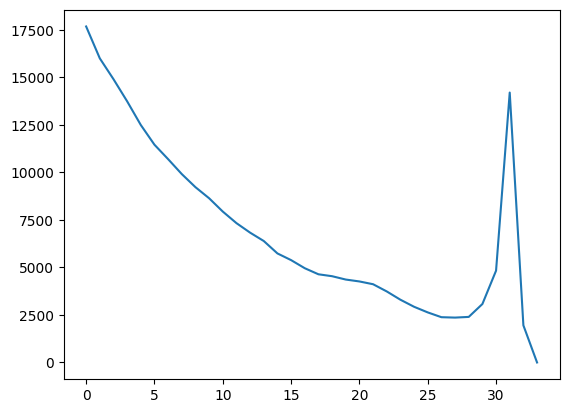

In [28]:
plt.plot(list(freq.values())[30:])